In [1]:
##Something is wrong when we insert back the idhogar (there are also 4 instances of it)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from scipy.stats import skew
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

In [3]:
def get_similar_cols(data, groupby):
    return data.filter(like=groupby, axis=1).columns.tolist()
    

In [4]:
class Preprocessing:
    def get_dummies(data, mult_Xlabels):
        return pd.get_dummies(data, columns=mult_Xlabels, drop_first=True)
    
    def get_label_encoder(data, mult_Xlabels):
        update_cols = data[mult_Xlabels].apply(preprocessing.LabelEncoder().fit_transform)
        data[mult_Xlabels] = update_cols
        return data
    
    def get_less_x_labels(data, threshold=10):
        categories = data.apply(lambda x: len(x.unique())).sort_values(ascending=True)
        values, labels = categories.values, categories.index
        values = [v for v in values if v <= treshold]
        labels = labels[:len(values)]
        return pd.DataFrame(values, index=labels)  
    
    def get_similar_cols(data, groupby):
        return data.filter(like=groupby, axis=1).columns.tolist()
    
    def add_similar_cols(data, groupby):
        cols = Preprocessing.get_similar_cols(data, groupby)
        return data[cols].sum(axis=1)
    
    def get_dtypes(data, verbose=False):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        numerics_cols = data.select_dtypes(include=numerics).columns
        object_cols = data.select_dtypes(include='object').columns
        if verbose:
            print('There are {0} numeric cols: {1}\nThere are {2} object cols: {3}\nThere are total cols: {4}'.format
                  (len(numerics_cols),numerics_cols, len(object_cols), object_cols, len(data.columns)))
        return [numerics_cols, object_cols]

In [5]:
train_set = pd.read_csv('./archive/train.csv')
test_set = pd.read_csv('./archive/test.csv')

# Adding a target variable to the testing eset
test_set['Target'] = None

# One additional we could do is to concantate the training and testing data
all_data = pd.concat((train_set, test_set), axis=0)

# Storing the predictor value
y_pred = all_data['Target']

# Storing the heads value
heads = all_data.loc[all_data['parentesco1'] == 1].copy()

# Labels for training
train_labels = all_data.loc[(all_data['Target'].notnull()) & (all_data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

In [6]:
# Shape of the training and testing set
train_set.shape, test_set.shape, all_data.shape

((9557, 143), (23856, 143), (33413, 143))

In [7]:
# More specific info on the training set
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [8]:
# More specific info on the testing set
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(129), object(6)
memory usage: 26.0+ MB


In [9]:
# Quick insight to the shape of the data
all_data.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Text(0.5,1,'Count of Unique Values in Integer Columns')

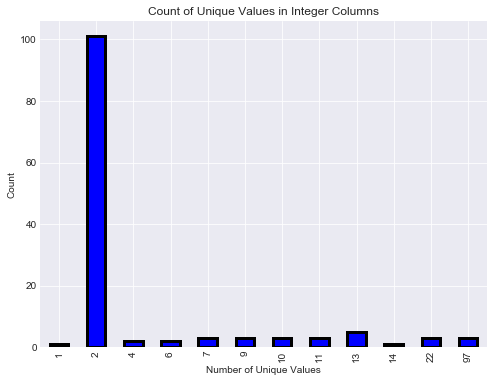

In [10]:
# Let dive into the variables, and the represenation of these variables
train_set.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(
    color='blue', figsize=(8,6), edgecolor="k", linewidth=3)
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns')

Notes:
- As we will notice, some of values not to be aggregated (since they are already at the household level).
- However, there will be other columns that will have to be aggregated since they are an individual level.

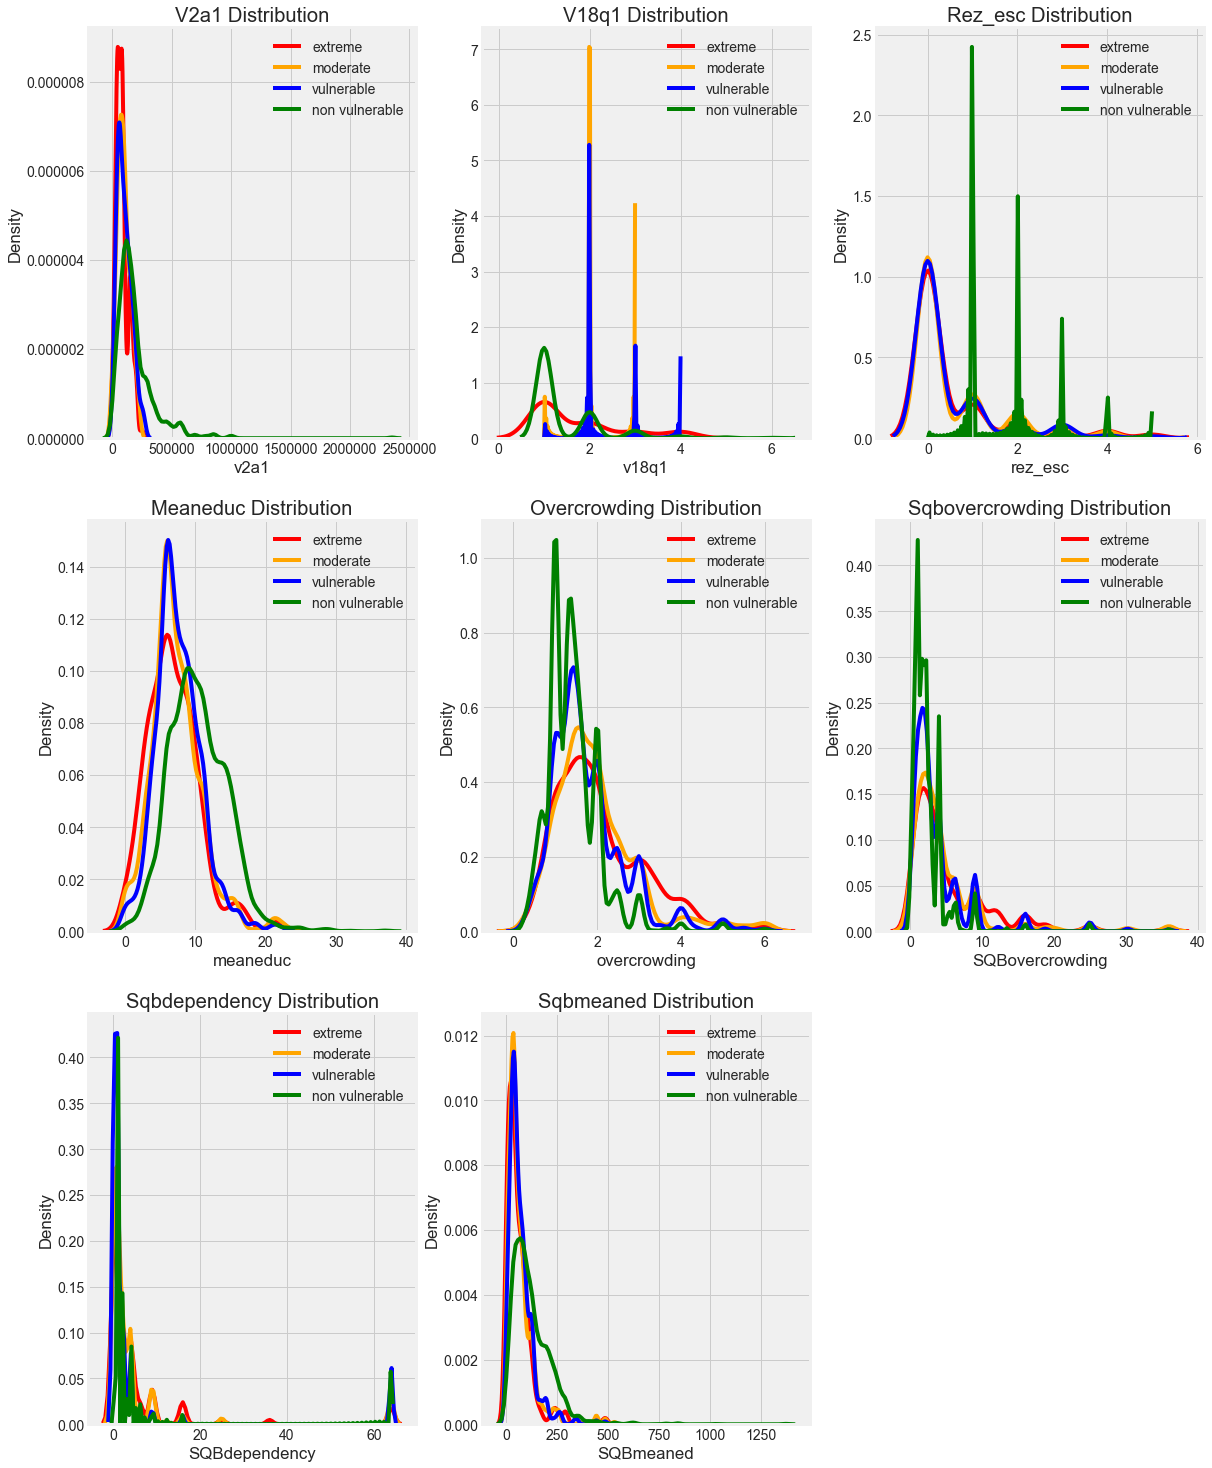

In [11]:
# Mapping the values of floating columns
from collections import OrderedDict

plt.figure(figsize = (20, 14))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train_set.select_dtypes('float')):
    ax = plt.subplot(4, 3, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [12]:
train_set.select_dtypes('object').head(5)

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Notes:
- Noticed that there's a mixture of integers and strings for the later 3 columns.
- The documenation states that the 3 latter columns should be yes and no (binary)

In [13]:
mapping_incorrections = {'yes': 1, 'no': 0}

# Reshaping the data based on this finding
for df in [train_set, test_set, all_data]:
    for col in ['dependency', 'edjefa', 'edjefe']:
        df[col] = df[col].replace(mapping_incorrections).astype(np.float64)

In [14]:
train_set[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


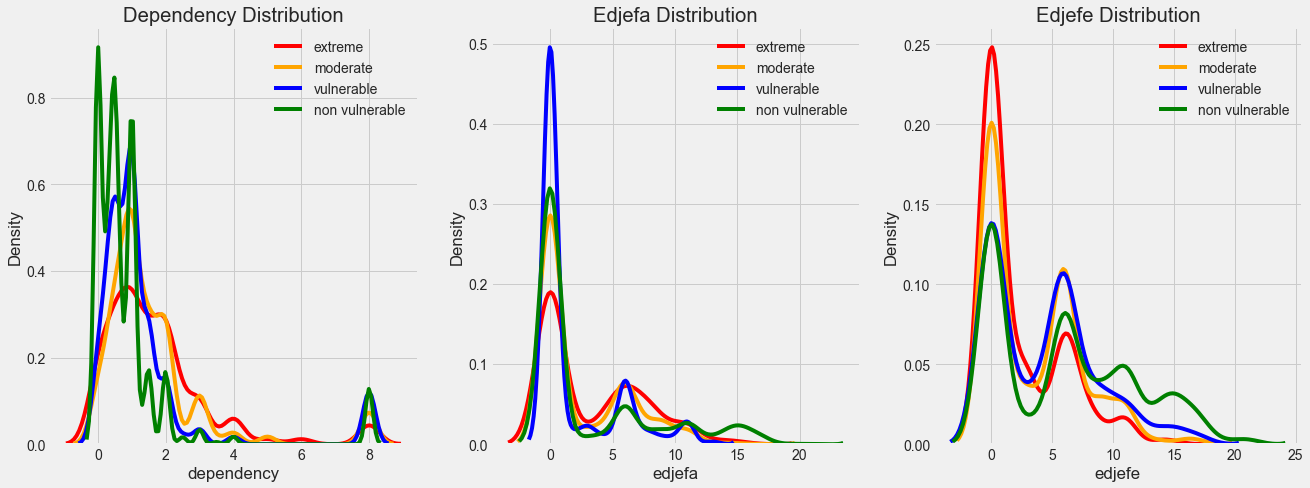

In [15]:
# A deeper distribution of the floating variables
plt.figure(figsize = (20, 3))

# Iterate through floats
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(1, 3, i + 1)
    
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        
        # Plot each poverty level as a separate line
        sns.kdeplot(train_set.loc[train_set['Target'] == poverty_level, col].dropna(), 
                    ax=ax, color=color, label= poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Notes
- The distribution among the four target variables are very similar. Thus, we cannot find too much information.

In [16]:
# SETTING UP VARIABLES THAT WILL BE USED
TARGET_AXIS_LABELS = ('extreme pov', 'moderate pov', 'vunerable hh', 'non-vunerable hh')

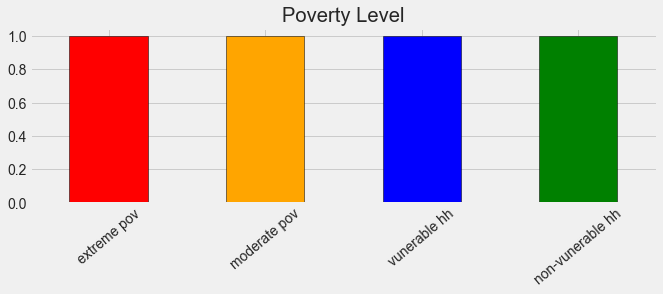

In [17]:
# Understanding the distribution of the target variable
plt_label_counts = label_counts.value_counts().plot(kind="bar", figsize=(10,3), color=colors.values(),
                                       edgecolor="k")
plt_label_counts.set_xticklabels(labels=TARGET_AXIS_LABELS, rotation=40)
plt.title("Poverty Level")
plt.show()

In [18]:
targets_sum = train_set['Target'].value_counts().sum()
targets_percent = []
for i, target in enumerate(train_set['Target'].value_counts()):
    percent = target/targets_sum
    targets_percent.append("Target {0}: Percentage of {1:.2f}".format(poverty_mapping[i+1], percent))
targets_percent

['Target extreme: Percentage of 0.63',
 'Target moderate: Percentage of 0.17',
 'Target vulnerable: Percentage of 0.13',
 'Target non vulnerable: Percentage of 0.08']

Notes
- Most of the values fall within the extreme poverty.
- Noticed that about 2/3 of the data is considered extreme poverty
- Less than 1/10 of the data indicates that people are non vunerable

In [19]:
train_set[train_set['idhogar']=="0172ab1d9"]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
7651,ID_a5e2b0639,NaN,0,5,0,1,1,0,NaN,0,...,49,196,25,36,4,2.777778,0.444444,58.777775,196,3
7652,ID_5dfdf4ebe,NaN,0,5,0,1,1,0,NaN,0,...,100,289,25,36,4,2.777778,0.444444,58.777775,289,2
7653,ID_762e1fd96,NaN,0,5,0,1,1,0,NaN,0,...,36,2601,25,36,4,2.777778,0.444444,58.777775,2601,3
7654,ID_c76b87004,NaN,0,5,0,1,1,0,NaN,0,...,36,2304,25,36,4,2.777778,0.444444,58.777775,2304,3
7655,ID_1dffe3dcf,NaN,0,5,0,1,1,0,NaN,0,...,121,441,25,36,4,2.777778,0.444444,58.777775,441,2


In [20]:
# Are there any other error? 
# Luckily, the author of a project, did explain that we do have info on the some errors
# We have to group all the id_hogar together
# Then, we are able to discover the Target variables for the idhogar. 
# There should only be one target value per idhogar

targets_all_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
targets_not_equal = targets_all_equal[targets_all_equal == False]
len(targets_not_equal)

85

Notes
- We have to assign the household member as the actual value to the idhogar of all its members

In [21]:
# Example
# Notice for the SAME household, we have target variables of 2 and 3
train_set[train_set["idhogar"] == targets_not_equal.index[0]]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
7651,ID_a5e2b0639,NaN,0,5,0,1,1,0,NaN,0,...,49,196,25,36,4,2.777778,0.444444,58.777775,196,3
7652,ID_5dfdf4ebe,NaN,0,5,0,1,1,0,NaN,0,...,100,289,25,36,4,2.777778,0.444444,58.777775,289,2
7653,ID_762e1fd96,NaN,0,5,0,1,1,0,NaN,0,...,36,2601,25,36,4,2.777778,0.444444,58.777775,2601,3
7654,ID_c76b87004,NaN,0,5,0,1,1,0,NaN,0,...,36,2304,25,36,4,2.777778,0.444444,58.777775,2304,3
7655,ID_1dffe3dcf,NaN,0,5,0,1,1,0,NaN,0,...,121,441,25,36,4,2.777778,0.444444,58.777775,441,2


In [22]:
# Another insight the analyst understood was that some household do not have any household leader
household_heads = train_set.groupby('idhogar')['parentesco1'].sum()

# Finding household without a head leader
household_no_heads_df = train_set.loc[train_set['idhogar'].isin(household_heads[household_heads == 0].index), :]
(household_no_heads_df['idhogar'].nunique())

15

Notes:
- There are 15 households that have no head household member


In [23]:
# Are there values that where there is no household leader and the member of the household have different 
# target variables
household_leaders_mismatched = household_no_heads_df.groupby('idhogar')['Target'].apply(
    lambda x: x.nunique() == 1)

# There are no variables where we have a mismatch btw family members
# and no household leader
sum(household_leaders_mismatched == False)

0

### Updating Data
- Now, we have to replace households that have different target variables with the household head target variable

In [24]:
for target in targets_not_equal.index:
    # Locate the true target from our series where targets are not equal among the same id_hogar
    # and the target that the head has
    true_target = int(train_set[(train_set['idhogar'] == target) 
                            & (train_set['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for the target
    train_set.loc[train_set['idhogar'] == target, "Target"] = true_target
    
# Let check if all household have the same target
target_all_equal = train_set.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
target_not_equal = target_all_equal[target_all_equal==False]

# Its' an empty series, we fixed the problem
target_not_equal

Series([], Name: Target, dtype: bool)

### Missing Data

In [25]:
# Separting the numeric and object columnac
num_cols, obj_cols = Preprocessing.get_dtypes(all_data, verbose=False)

In [26]:
def missing_values(data, cols):
    missing_percent = data[cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    missing_abs = data[cols].apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    df = pd.DataFrame({'Missing': missing_abs, 'Percent': missing_percent})
    return df.loc[~(df==0).all(axis=1)]

In [27]:
nums_missing_df = missing_values(all_data, num_cols)
nums_missing_df

,Missing,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077


In [28]:
def plot_value_counts(df, col, heads_only=False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 5))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();


#### Missing Value: v18q1

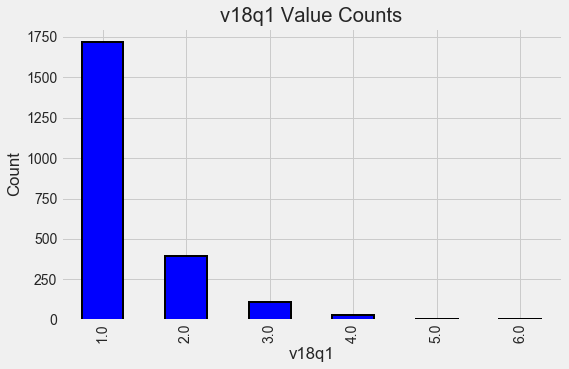

In [29]:
plot_value_counts(heads, 'v18q1')

Notes:
- We CANNOT conclude that we should replace the missing values with 1.
- Since, the family might not own a tablet (thus, we would replace the missing data with 0)
- We need to check the binary column ('v18q') to further investigate the missing value

In [30]:
# We need to group the heads dataframe with v18q and see the null values 
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Notes:
- Notice that all values that are 0 in the v18q column (binary if a person owns a tablet), for every value that v18q1 is null, it is also label as 0

In [31]:
# Filling in the missing value
all_data['v18q'] = all_data['v18q'].fillna(0)

#### Missing Value: v2a1, Monthly rent payment

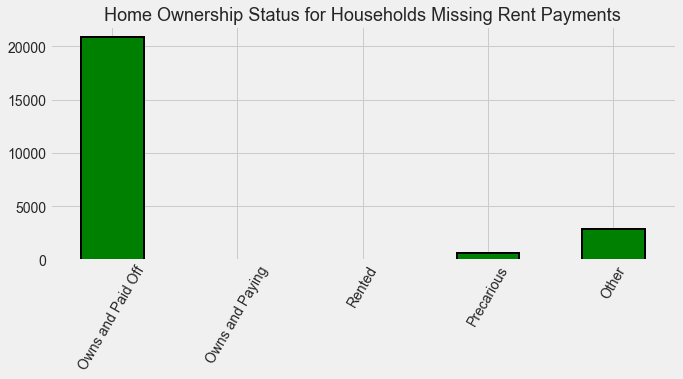

In [32]:
# Variables indicating home ownership
ownership_ctgy = [x for x in all_data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
all_data.loc[all_data['v2a1'].isnull(), ownership_ctgy].sum().plot.bar(figsize = (10, 4),
                                                                       color = 'green',
                                                                       edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

Notes: 
- For the most part, we answered the problem. People who had missing payment meant that they own the property.
- However, there are still values that indicate missing values.


In [33]:
# Updating the payment to 0 for people who own the property
all_data.loc[(all_data['v2a1'].isnull()) & (all_data['tipovivi1'] == 1), "v2a1"] = 0

# Creating an additional boolean values of people who have missing values
all_data['v2a1-missing'] = all_data['v2a1'].isnull()
all_data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

#### Missing Value: rez_esc: years behind in school

In [34]:
# Checking the age of people who have null values as years behind in school
all_data.loc[all_data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [35]:
# Will need to compare this with values that are not null
all_data.loc[all_data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

Notes:
- You cannot be years in school if you are not in school. 
- Thus, we can make this value 0 if you are younger than 7 or older than 19 

In [36]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
all_data.loc[((all_data['age'] > 19) | (all_data['age'] < 7)) & (all_data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
all_data['rez_esc-missing'] = all_data['rez_esc'].isnull()

In [37]:
# Notice that there is an outlier
# We need to find a method where we can collect outliers (either based on what the value should be or anything
# anything funky in the data)

print(all_data['rez_esc'].value_counts())
all_data.loc[all_data['rez_esc'] > 5, 'rez_esc'] = 5

0.0     30894
1.0       728
2.0       336
3.0       174
4.0        80
5.0        39
99.0        1
Name: rez_esc, dtype: int64


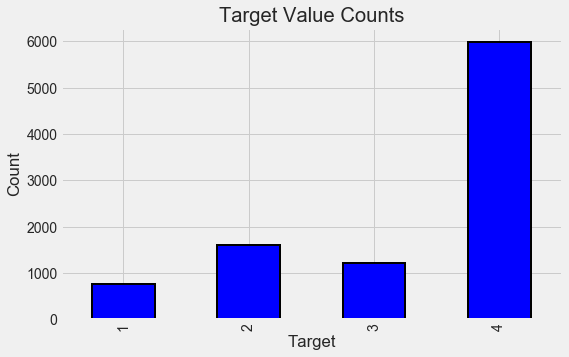

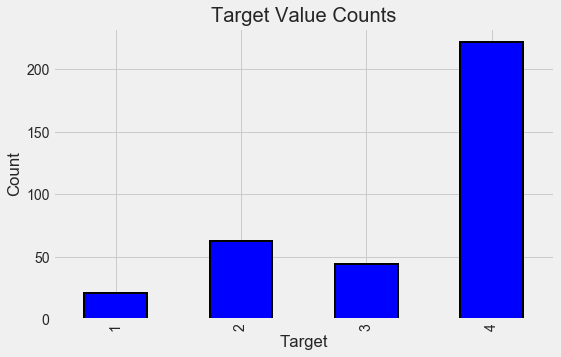

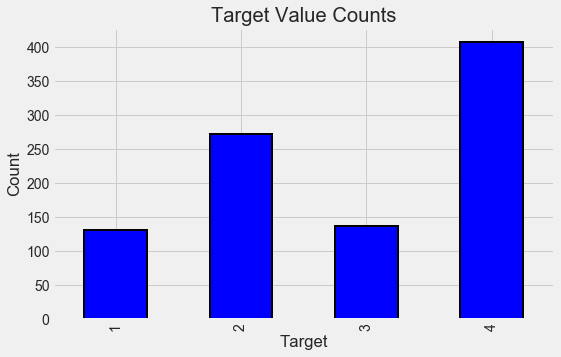

In [38]:
# Understanding how the data is related with and with not the missing values 
plot_value_counts(all_data, 'Target')
plot_value_counts(all_data[all_data['rez_esc-missing'] == 1], 'Target')
plot_value_counts(all_data[all_data['v2a1-missing'] == 1], 'Target')

Notes:
- Noticed that the distriution for the rez_esc_missing has a similar dist. as the data. However, the v2a1-missing has a different dist. than the data
- The missing information can be just as valuable as the data.

### Feature Enginnering

A concise format of how to approach the grouping. (I did manage to this without much guidance). But I do appreciate this workbook is able to consisely explain the process I followed.

Define Variable Categories

There are several different categories of variables:

Individual Variables: these are characteristics of each individual rather than the household
- Boolean: Yes or No (0 or 1)
- Ordered Discrete: Integers with an ordering

Household variables
- Boolean: Yes or No
- Ordered Discrete: Integers with an ordering

Continuous numeric
- Squared Variables: derived from squaring variables in the data
- Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [39]:
# Correctly labeling the data
# Unfortunaly, since the data cannot be structured, I think it's worthwhile to look at the data

# Ids
id_ = ['Id', 'idhogar', 'Target']

# Looking at individuals variables (meaning individuals in the same household should have diff. values)
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco1', 
            'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 
            'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 'parentesco11', 
            'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 
            'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

# Looking at households variables
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 'paredpreb',
           'pisocemento', 'pareddes', 'paredmad','paredzinc', 'paredfibras', 'paredother', 
           'pisomoscer', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera','techozinc', 
           'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 'abastaguadentro', 
           'abastaguafuera', 'abastaguano', 'public', 'planpri', 'noelec', 'coopele', 
           'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6', 'energcocinar1', 
           'energcocinar2', 'energcocinar3', 'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3', 
           'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3', 'etecho1', 
           'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 'tipovivi1', 'tipovivi2', 'tipovivi3', 
           'tipovivi4', 'tipovivi5', 'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = ['rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

# Storing the squared variables
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 
        'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


In [40]:
# Double checking there are no repated variables and they are in the list
from collections import Counter

columns_x = id_ + ind_bool + ind_ordered + hh_bool + hh_cont + hh_ordered + sqr_
print('There are no repeated values', np.all(np.array(list(Counter(columns_x).values())) == 1))
print('We covered every variable: ', len(columns_x) == all_data.shape[1])


There are no repeated values True
We covered every variable:  True


### Analyzing Based on Column Type

#### Squared Columns

In [41]:
# Removing sq variables (they do not add any value since we have the original values)
all_data = all_data.drop(sqr_, axis=1)
all_data.shape

(33413, 136)

#### Id Columns

In [42]:
# Id columns should be kept since we need to maintain the same structure

#### Household Level Variables

In [43]:
# Subset of the household memebers and their variables
hh_vars = hh_bool + hh_cont + hh_ordered + id_
heads = all_data.loc[all_data['parentesco1'] == 1, hh_vars]
heads.shape

(10307, 99)

Notes:
- We do not need to make much adjustments. However, we could look at values that are too redundant.

In [44]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [45]:
# dataframes that have a high correlation with the correlation values we found above
for drop in to_drop:
    corr_df = corr_matrix.loc[corr_matrix[drop].abs() > 0.9, corr_matrix[drop].abs() > 0.9]
    print(corr_df)


           public   coopele
public   1.000000 -0.967759
coopele -0.967759  1.000000
       area1  area2
area1    1.0   -1.0
area2   -1.0    1.0
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3         1.000000  0.998287  0.910457  0.998287     0.998287
tamhog       0.998287  1.000000  0.909155  1.000000     1.000000
tamviv       0.910457  0.909155  1.000000  0.909155     0.909155
hhsize       0.998287  1.000000  0.909155  1.000000     1.000000
hogar_total  0.998287  1.000000  0.909155  1.000000     1.000000
                 r4t3    tamhog    tamviv    hhsize  hogar_total
r4t3       

Notes:
- Perfect correlated values are 
    - hhsize & tmhog
    - hogar_total & hhsize
    - area1 & area2
- Highly correlated values are
    - r4t3 & hhsize
    - r4t3 & hogar_total
    
    
- r4t3, Total persons in the household
- tamhog, size of the household
- tamviv, number of persons living in the household
- hhsize, household size
- hogar_total, # of total individuals in the household

Notice that tamhog, hhsize, and hogar_total are the same variables (could drop two of these)

tamviv does not represent the same as the other values because it indicates how may people are actually in the household. Meaning, we could have more members in the household than the household

In [46]:
heads.drop(['tamhog', 'hogar_total', 'r4t3'], inplace=True, axis=1)

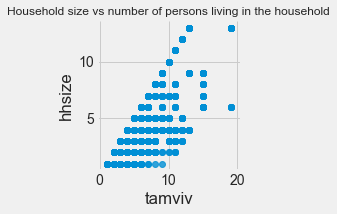

In [47]:
# Visualize hhsize and tamviv
sns.lmplot('tamviv', 'hhsize', all_data, fit_reg=False, size = 3);
plt.title('Household size vs number of persons living in the household', fontdict={'fontsize': 12});

Notes:
- Since there is a difference, the difference could be a new feature we can add for our data!

In [48]:
# The results are too surpising. Most do not have extra memebers in the households.

heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
heads['hhsize-diff'].value_counts()

0     9901
1       98
2       90
3       84
4       61
5       28
6       14
7       11
8       11
9        8
13       1
Name: hhsize-diff, dtype: int64

In [49]:
# Correlated Values: coopele
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
heads.drop(['noelec', 'coopele', 'public', 'planpri'], axis=1, inplace=True)

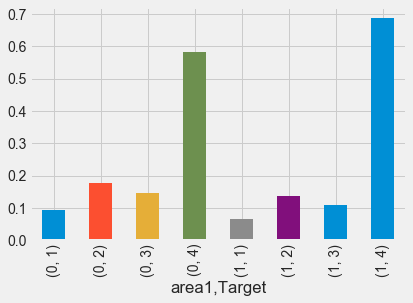

In [50]:
# The final redundant column is area2. 
# This means the house is in a rural zone, but it's redundant because 
# we have a column indicating if the house is in a urban zone. Therefore, we can drop this column.
#heads.drop(['area2'], axis=1, inplace=True)

# Observe how area affects the target variables
heads.groupby('area1')['Target'].value_counts(normalize=True).sort_index().plot(kind="bar")

Notes:
- It seems like households in an urban area (value of 1) are more likely to have lower poverty levels than households in a rural area (value of 0).

#### Creating Ordinal Variables

In [51]:
# Wall Ordinal Variables

walls_columns = get_similar_cols(all_data, groupby='epared')
heads['walls'] = np.argmax(np.array(heads[walls_columns]), axis=1)
heads.drop(walls_columns, axis=1, inplace=True)

In [52]:
# Roof Ordinal Variables

roof_columns = get_similar_cols(all_data, groupby='etecho')
heads['roof'] = np.argmax(np.array(heads[roof_columns]), axis=1)
heads.drop(roof_columns, axis=1, inplace=True)

In [53]:
# Floor Ordinal Variables

floor_columns = get_similar_cols(all_data, groupby='eviv')
heads['floor'] = np.argmax(np.array(heads[floor_columns]), axis=1)
heads.drop(floor_columns, axis=1, inplace=True)

### Feature Construction

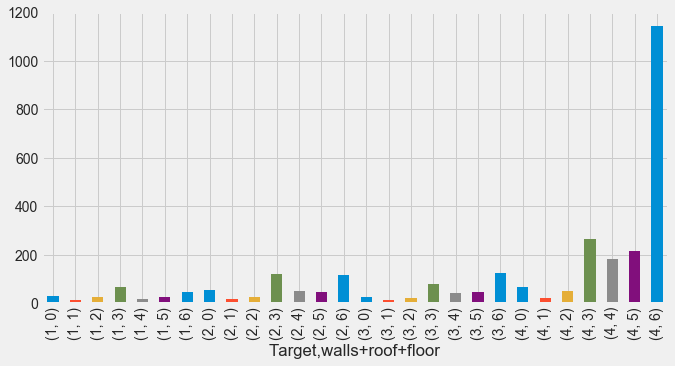

In [54]:
# Create new feature
plt.figure(figsize = (10, 5))
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
heads.groupby('Target')['walls+roof+floor'].value_counts().sort_index().plot(kind="bar")

Notes:
- This new feature may be useful because it seems like a Target of 4 (the lowest poverty level) tends to have higher values of the 'house quality' variable. 

In [55]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(
    columns = {'Target': 'Normalized Count'}).reset_index()
counts.head(5)

,walls+roof+floor,Target,Normalized Count
0,0,4,0.376404
1,0,2,0.320225
2,0,1,0.162921
3,0,3,0.140449
4,1,4,0.323529


In [56]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + (heads['elec'] == 0) + 
                        heads['pisonotiene'] + heads['abastaguano'] + 
                        (heads['cielorazo'] == 0))

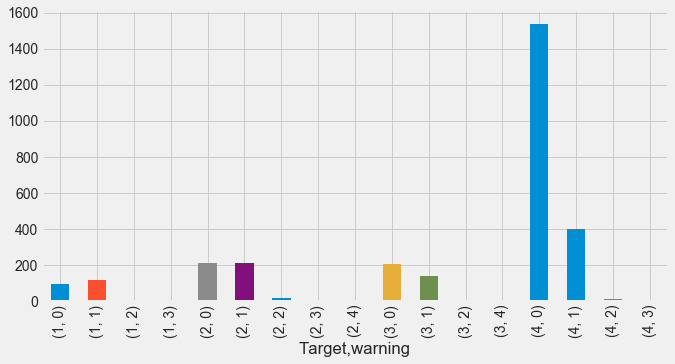

In [57]:
plt.figure(figsize = (10, 5))
heads.groupby('Target')['warning'].value_counts().sort_index().plot(kind="bar")

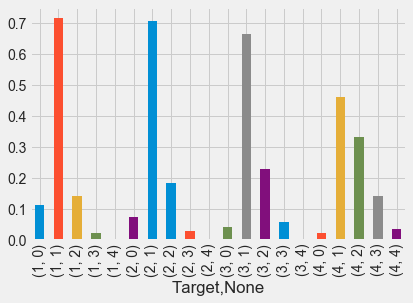

In [58]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

heads.groupby('Target')['bonus'].apply(lambda x: x.value_counts()/len(x)).sort_index().plot(kind="bar")

#### Per Capita Features

In [59]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

### Exploring Household Variables¶


There are a numerous method to measure to relationship btw two variables:
- The Pearson Correlation: from -1 to 1 measuring the linear relationship between two variables 
- The Spearman Correlation: from -1 to 1 measuring the monotonic relationship between two variables
- The Spearman correlation is 1 if as one variable increases, the other does as well, even if the relationship is not linear. On the other hand, the Pearson correlation can only be one if the increase is exactly linear. These are best illustrated by example.


#### Pearson Correlation


Pearson Correlation Guidelines:
- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [60]:
# Only focusing on the training set
heads_train = heads.loc[heads['Target'].notnull(), :].copy()
heads_train['Target'] = heads_train['Target'].astype('int64')
pcorrs = pd.DataFrame(heads_train.corr()['Target'].sort_values(ascending=False)).rename(columns=
                                                                        {"Target": 'P_corr'}).reset_index()

pcorrs = pcorrs.rename(columns = {'index': 'feature'})
#pcorrs.drop(['Target'], axis=1, inplace=True)
pcorrs.head(6)[1:]

,feature,P_corr
1,meaneduc,0.333652
2,walls+roof+floor,0.332446
3,floor,0.307605
4,phones-per-capita,0.299026
5,walls,0.298737


In [61]:
pcorrs.dropna().tail(5)

,feature,P_corr
88,r4m1,-0.209479
89,overcrowding,-0.234954
90,r4t1,-0.260917
91,hogar_nin,-0.266309
92,warning,-0.301791


Notes:
- Negative correlation: as we increase the value, poverty will increase. E.g. as our warning increases, the level of poverty will begin to decrease. 
- Overcrowing and hogar_nin (children under the age of 19) worsen poverty for households.
- For the positive values, walls, roof, and floor indicates that an improvement in those variables will eventually decrease poverty.

#### Spearman Correlation

In [62]:
import warnings
from scipy.stats import spearmanr

warnings.filterwarnings('ignore', category = RuntimeWarning)

feats = []
scorr = []
pvalues = []

# Iterate through each column
for c in heads:
    # Only valid for numbers
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # Calculate spearman correlation
        scorr.append(spearmanr(heads_train[c], heads_train['Target']).correlation)
        pvalues.append(spearmanr(heads_train[c], heads_train['Target']).pvalue)

scorrs = pd.DataFrame({'feature': feats, 'S_corr': scorr, 'pvalue': pvalues}).sort_values('S_corr', ascending=False)
scorrs.head(5)

,feature,S_corr,pvalue
86,walls+roof+floor,0.338791,9.539346e-81
89,phones-per-capita,0.337377,4.760104e-80
85,floor,0.309638,4.466091e-67
22,cielorazo,0.300996,2.611808e-63
83,walls,0.298963,1.925370e-62


In [63]:
scorrs.dropna().tail(5)

,feature,S_corr,pvalue
7,pisocemento,-0.209387,8.270816e-31
70,r4t1,-0.219226,1.112230e-33
75,hogar_nin,-0.236225,5.567218e-39
58,dependency,-0.281516,2.792620e-55
87,warning,-0.307326,4.682829e-66


In [64]:
# Notice that both correlation matrix have identical values
# lets find their differences
corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['P_corr'] - corrs['S_corr']
corrs['abs_diff'] = np.abs(corrs['diff'])
corrs.sort_values(by='diff', ascending=False).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
78,dependency,-0.126465,-0.281516,2.792620e-55,0.155051,0.155051
31,edjefa,0.052310,0.005114,7.804715e-01,0.047197,0.047197
10,edjefe,0.235687,0.214736,2.367521e-32,0.020951,0.020951
46,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549,0.016549
39,techozinc,0.014357,0.003404,8.528369e-01,0.010954,0.010954


In [65]:
corrs.sort_values(by='diff', ascending=True).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
19,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119,0.071119
89,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691,0.041691
3,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351,0.038351
87,r4m1,-0.209479,-0.171953,3.649343e-21,-0.037526,0.037526
90,hogar_nin,-0.266309,-0.236225,5.567218e-39,-0.030084,0.030084


In [66]:
# Lets look at the 6 most correlated values
corrs.sort_values(by=['S_corr']).head(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
91,warning,-0.301791,-0.307326,4.682829e-66,0.005534,0.005534
78,dependency,-0.126465,-0.281516,2.792620e-55,0.155051,0.155051
90,hogar_nin,-0.266309,-0.236225,5.567218e-39,-0.030084,0.030084
89,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691,0.041691
86,pisocemento,-0.209131,-0.209387,8.270816e-31,0.000256,0.000256


In [67]:
corrs.dropna().sort_values(by=['S_corr']).tail(5)

,feature,P_corr,S_corr,pvalue,diff,abs_diff
4,walls,0.298737,0.298963,1.925370e-62,-0.000226,0.000226
5,cielorazo,0.295249,0.300996,2.611808e-63,-0.005746,0.005746
2,floor,0.307605,0.309638,4.466091e-67,-0.002034,0.002034
3,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351,0.038351
1,walls+roof+floor,0.332446,0.338791,9.539346e-81,-0.006345,0.006345


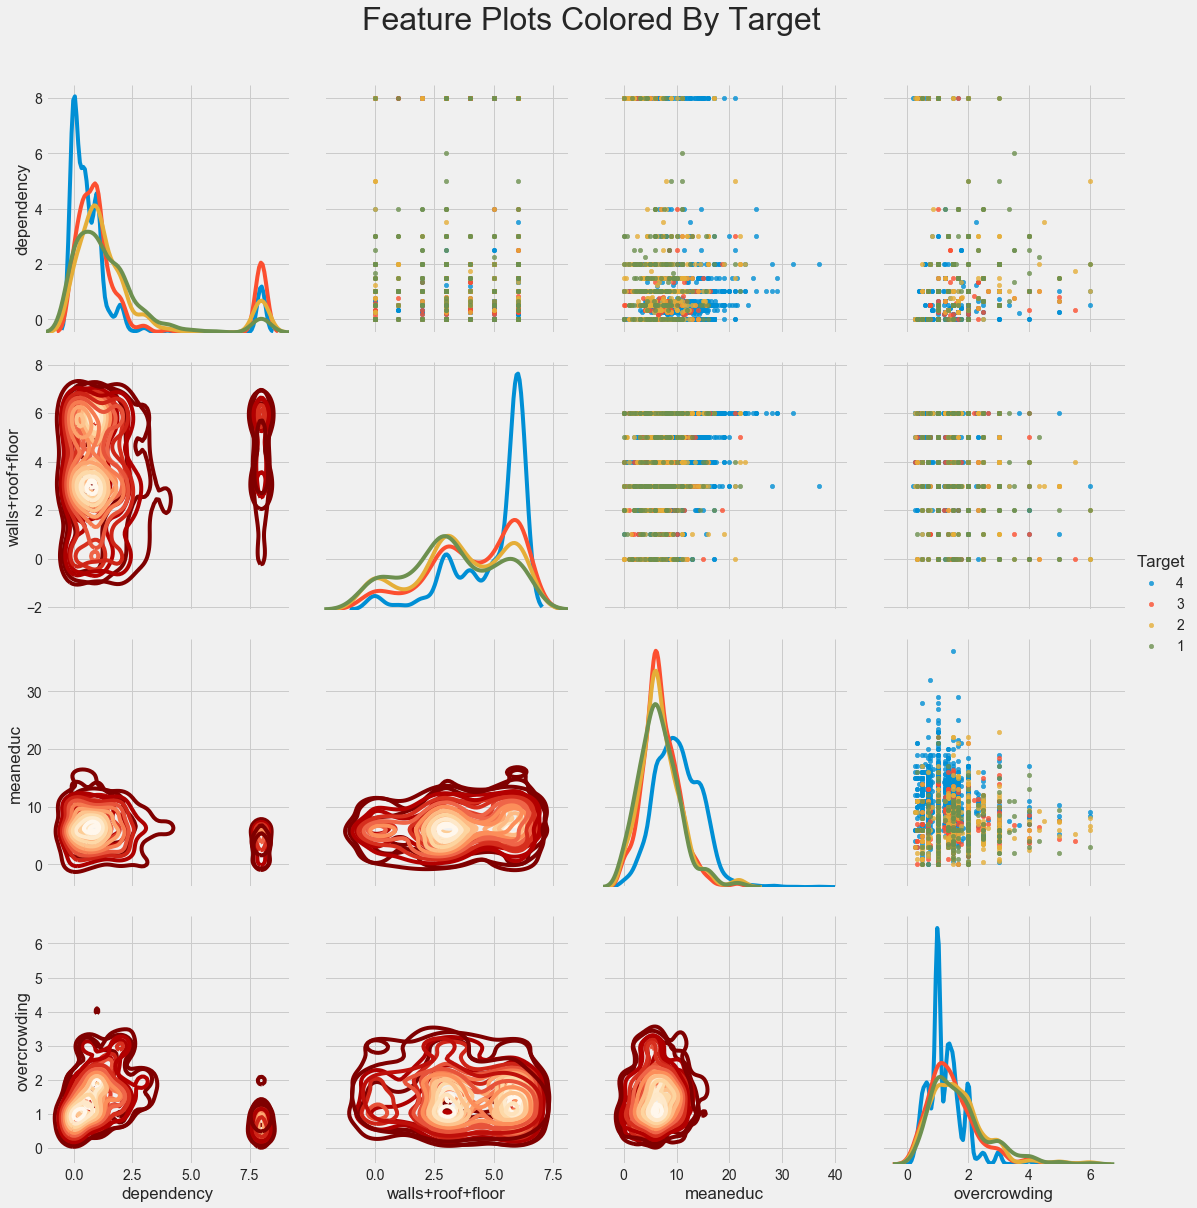

In [68]:
import warnings
warnings.filterwarnings('ignore')

# Chosen by the author of the workbook
plot_data = heads_train[['Target', 'dependency', 'walls+roof+floor',
                         'meaneduc', 'overcrowding']]

# Create the pairgrid object
grid = sns.PairGrid(data=plot_data, size=4, diag_sharey=False,
                    hue='Target', hue_order=[4, 3, 2, 1], 
                    vars=[x for x in list(plot_data.columns) if x != 'Target'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.8, s = 20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);
grid = grid.add_legend()
plt.suptitle('Feature Plots Colored By Target', size = 32, y = 1.05);

In [69]:
# Storing the household columns
household_feats = list(heads.columns)

### Individial Variables

In [70]:
ind = all_data[id_+ind_bool+ind_ordered]
ind.shape

(33413, 40)

In [71]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [72]:
# We already have the male variable, lets keep the female variables
ind.drop(['male'], axis=1, inplace=True)

#### Ordinal Variables

In [73]:
instl_vars = Preprocessing.get_similar_cols(ind, 'instl')
ind[instl_vars].head(5)

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


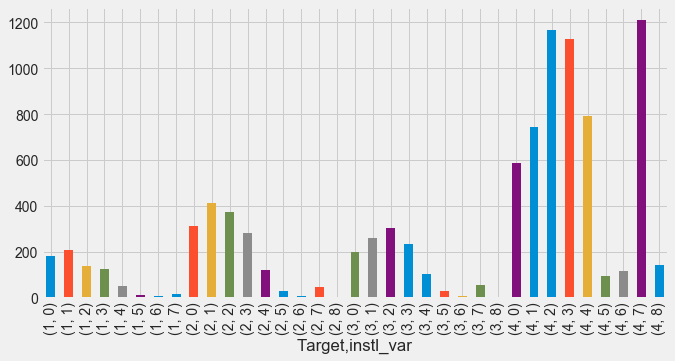

In [74]:
ind['instl_var'] = np.argmax(np.array(ind[[c for c in instl_vars]]), axis=1)
plt.figure(figsize = (10, 5))
ind.groupby('Target')['instl_var'].value_counts().sort_index().plot(kind="bar")
#.plot(kind='bar', )

Notes:
- Higher level of education can reduce poverty

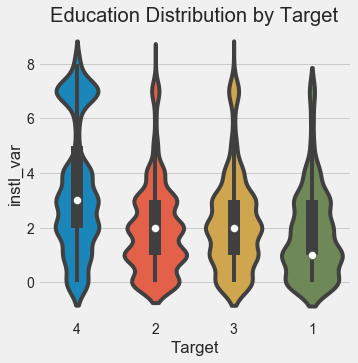

In [75]:
plt.figure(figsize = (5, 5))
sns.violinplot(x='Target', y='instl_var', data=ind);
plt.title('Education Distribution by Target');

In [76]:
ind.shape

(33413, 40)

### Feature Construction

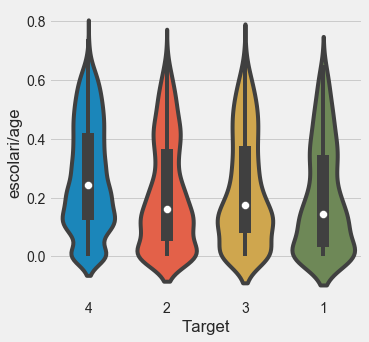

In [77]:
# Dividing the number of schools by the age
ind['escolari/age'] = ind['escolari'] / ind['age']

# Plotting the values
plt.figure(figsize = (5, 5))
sns.violinplot('Target', 'escolari/age', data = ind);

In [78]:
# Finding the ratio of higher level of education with ages
ind['instl_var/age'] = ind['instl_var']/ind['age']

In [79]:
# Adding all the tech gadgets
ind['tech'] = ind['v18q'] + ind['mobilephone']

### Featire Engineering: Aggregations

In [80]:
# Creating the range functions
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(['Target'], axis=1).groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                           dis                ...    \
           min max sum count  std range_ min max sum count  ...     
idhogar                                                     ...     
000a08204    1   1   3     3  0.0      0   0   0   0     3  ...     
000bce7c4    0   0   0     2  0.0      0   0   1   1     2  ...     
001845fb0    0   0   0     4  0.0      0   0   0   0     4  ...     
001ff74ca    1   1   2     2  0.0      0   0   0   0     2  ...     
003123ec2    0   0   0     4  0.0      0   0   0   0     4  ...     

          instl_var/age                           tech                     \
                    sum count       std    range_  min max sum count  std   
idhogar                                                                     
000a08204      0.483333     3  0.139775  0.250000    2   2   6     3  0.0   
000bce7c4      0.016667     2  0.011785  0.016667    1   1   2     2  0.0   
001845fb0      0.511959     4  0.060123  0.128205    1   1   4     4  0.0   
001ff74ca      0.184211     1       NaN  0.000000    2   2   4     2  0.0   
003123ec2      0.213768     4  0.064636  0.130435    1   1   4     4  0.0   

                  
          range_  
idhogar           
000a08204      0  
000bce7c4      0  
001845fb0      0  
001ff74ca      0  
003123ec2      0  

[5 rows x 234 columns]

In [81]:
# Renaming the aggreagation columns
new_col = []
for col in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{col}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head(5)

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,...,instl_var/age-sum,instl_var/age-count,instl_var/age-std,instl_var/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,...,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,...,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,...,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,...,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,...,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


### Feature Selection: "ind_agg"

In [82]:
def get_corrs_selection(data, max_corr=.95):
    corr_matrix = data.corr()
    
    # Select upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > max_corr)]
    
    return to_drop

In [83]:
ind_agg_to_drop = get_corrs_selection(ind_agg)
len(ind_agg_to_drop)

111

In [84]:
ind_agg = ind_agg.drop(ind_agg_to_drop, axis=1)
ind_feats = ind_agg.columns.tolist()

In [85]:
# Merging with household data
final_ = heads.merge(ind_agg, on='idhogar', how='left')

print("Shape of the final dataset is {}".format(final_.shape))

Shape of the final dataset is (10307, 219)


### Data Exploration

In [86]:
final_['Target'] = final_['Target'].dropna().astype('int64')
corrs = final_.corr()['Target']
corrs.sort_values().head()

warning          -0.301791
instlevel2-sum   -0.297868
instlevel1-sum   -0.271204
hogar_nin        -0.266309
r4t1             -0.260917
Name: Target, dtype: float64

In [87]:
corrs.sort_values(ascending=False).head(6)[1:]

escolari-max        0.373091
instl_var-max       0.368229
meaneduc            0.333652
walls+roof+floor    0.332446
instlevel8-max      0.317815
Name: Target, dtype: float64

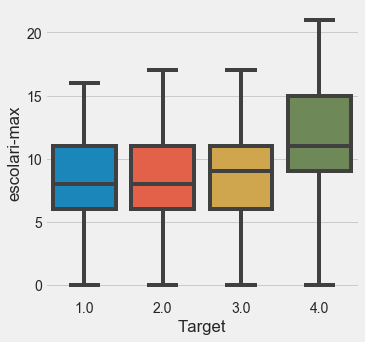

In [88]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='escolari-max', data=final_)

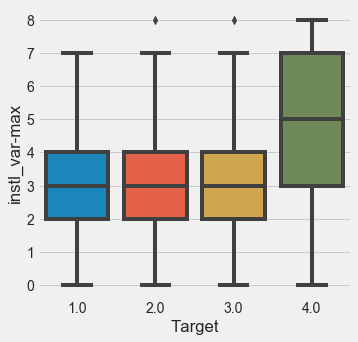

In [89]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='instl_var-max', data=final_)

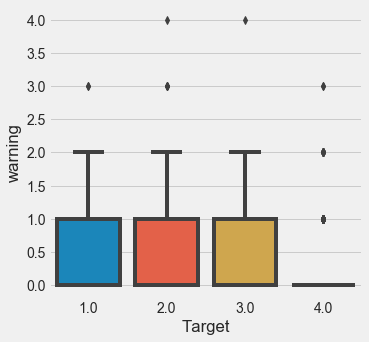

In [90]:
# Plotting boxplots for highly correlates values
plt.figure(figsize=(5,5))
sns.boxplot(x='Target', y='warning', data=final_)

In [91]:
# Finding female head gender
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final_ = final_.merge(head_gender, on='idhogar', how='left').rename(columns={'female': 'female-head'})

In [92]:
final_.groupby('female-head')['Target'].value_counts(normalize=True)


female-head  Target
0            4.0       0.682873
             2.0       0.136464
             3.0       0.123204
             1.0       0.057459
1            4.0       0.617369
             2.0       0.167670
             3.0       0.113500
             1.0       0.101462
Name: Target, dtype: float64

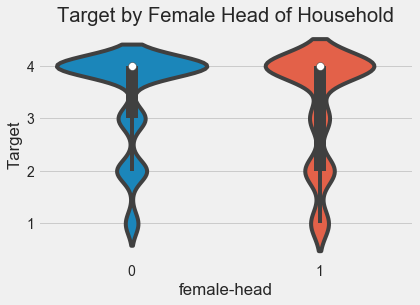

In [93]:
sns.violinplot(x='female-head', y='Target', data=final_);
plt.title('Target by Female Head of Household');

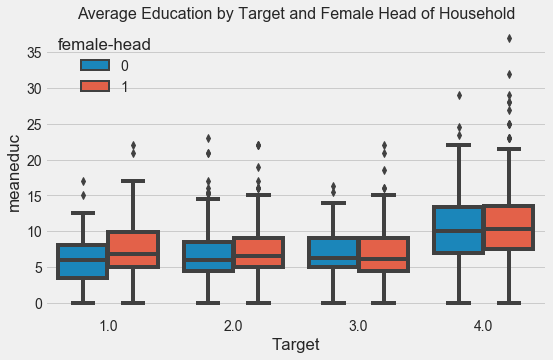

In [94]:
plt.figure(figsize = (8, 5))
sns.boxplot(x='Target', y='meaneduc', hue='female-head', data=final_);
plt.title('Average Education by Target and Female Head of Household', size = 16);

In [95]:
final_.groupby('female-head')['meaneduc'].agg(['mean', 'count'])

,mean,count
female-head,,
0,8.968025,6384
1,9.237013,3903


Notes:
- Despite females having higher levels of education, we can see that they will have higher less of poverty if they are the head of the household.

## Machine Learning Modeling

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [97]:
final_.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,escolari/age-std,escolari/age-range_,instl_var/age-max,instl_var/age-std,instl_var/age-range_,tech-min,tech-sum,tech-std,tech-range_,female-head
0,0,0,1,1,1,0,0,0,0,0,...,NaN,0.000000,0.069767,NaN,0.000000,1,1,NaN,0,0
1,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.104478,NaN,0.000000,2,2,NaN,0,0
2,0,0,1,1,0,0,0,0,0,1,...,NaN,0.000000,0.043478,NaN,0.000000,0,0,NaN,0,1
3,0,0,1,1,1,0,0,0,0,0,...,0.126943,0.279412,0.176471,0.033010,0.071207,2,8,0.0,0,0
4,1,0,1,1,1,0,0,0,0,0,...,0.168946,0.392857,0.142857,0.060063,0.142857,1,4,0.0,0,0


In [98]:
# Labels for training
train_labels = np.array(list(final_[final_['Target'].notnull()]['Target'].astype(np.uint8)))

# Extracting the training/testing set
train_on = final_[final_['Target'].notnull()]
train_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

test_on = final_[final_['Target'].isnull()]
test_on.drop(['Id', 'idhogar', 'Target'], axis=1, inplace=True)

# Submission base which is used for making submissions to the competition
submission_base = test_set[['Id', 'idhogar']].copy()

In [138]:

# Saving the sets for future use
np.save("./pickles/", train_labels, allow_pickle=True)
np.save("./pickles/", train_on, allow_pickle=True)
np.save("./pickles/", test_on, allow_pickle=True)
np.save("./pickles/", submission_base, allow_pickle=True)


In [99]:
# Filling Missing Values/Normalizing the data
features = list(train_on.columns)

# Creating the pipeline
pipeline = Pipeline([('imputer', Imputer(strategy='mean')), 
                     ('scalar', MinMaxScaler())])

# Fit and transform training data
train_on = pipeline.fit_transform(train_on)
test_on = pipeline.transform(test_on)

In [100]:
# Quick Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

# 10 fold cross validation
cv_score = cross_val_score(model, train_on, train_labels, cv=10, scoring=scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.3514 with std = 0.0411


## Feauture Importance

In [102]:
model.fit(train_on, train_labels)

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,hacdor,0.000604
1,hacapo,0.000397
2,v14a,0.000391
3,refrig,0.001951
4,paredblolad,0.005684


In [128]:
def plot_feature_importances(df, n = 10, threshold = None):
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

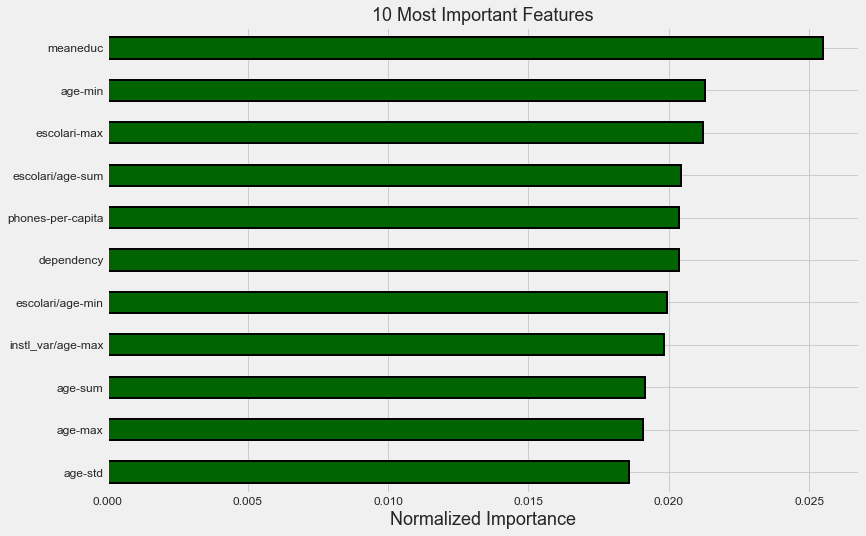

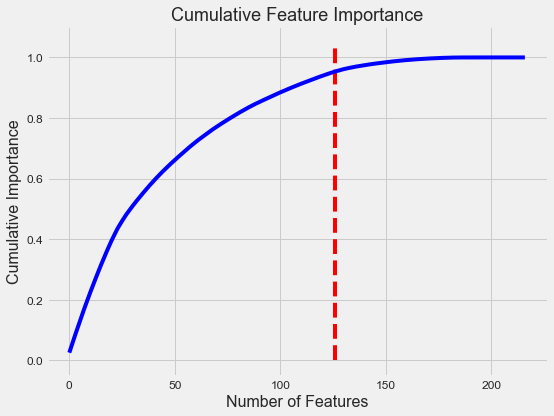

126 features required for 95% of cumulative importance.


In [129]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)


Notes:
- Realize that we do not need all the variable to have a high importance of the data
- Also, the importance does not tell its affect on the target variable
- Lastly, we need to be reassured of the variables that could be correlated with one another.

In [130]:
def kde_target(df, variable):
    """Plots the distribution of `variable` in `df` colored by the `Target` column"""
    
    colors = {1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}

    plt.figure(figsize = (12, 8))
    
    df = df[df['Target'].notnull()]
    
    for level in df['Target'].unique():
        subset = df[df['Target'] == level].copy()
        sns.kdeplot(subset[variable].dropna(), 
                    label = f'Poverty Level: {level}', 
                    color = colors[int(subset['Target'].unique())])

    plt.xlabel(variable); plt.ylabel('Density');
    plt.title('{} Distribution'.format(variable.capitalize()));

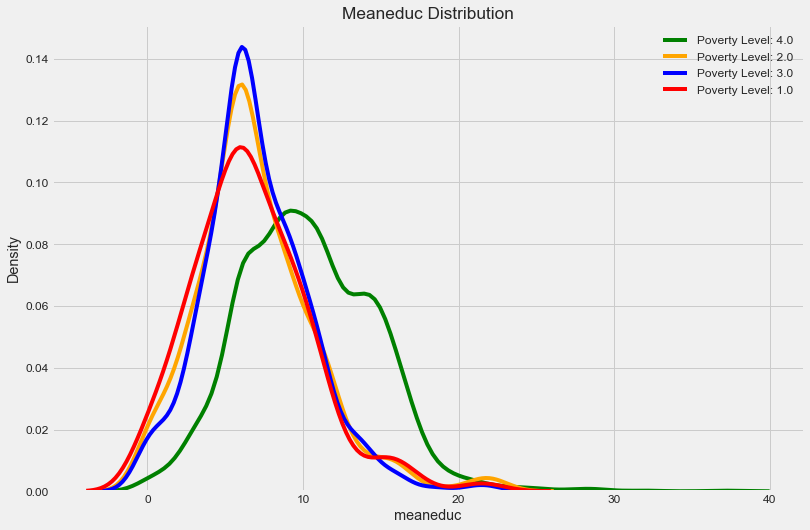

In [132]:
kde_target(final_, 'meaneduc')


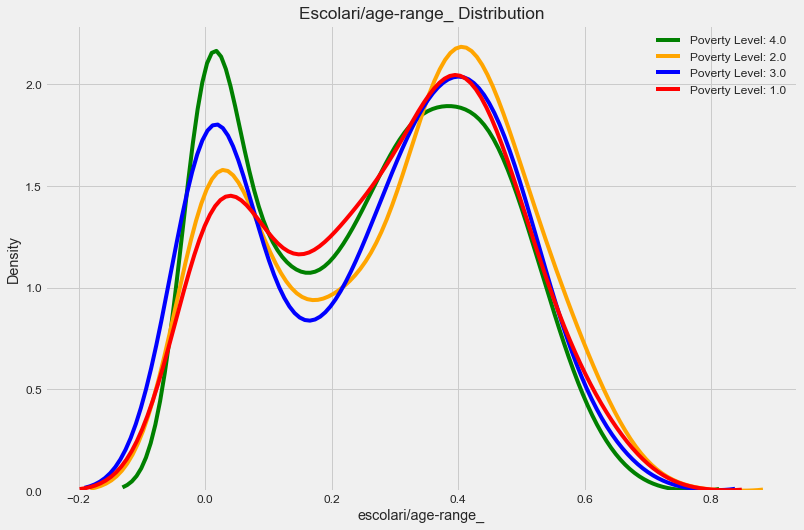

In [133]:
kde_target(final_, 'escolari/age-range_')


## Models

In [141]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [139]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                           'cv_std': cv_scores.std()},
                                                           index = [0]), ignore_index = True)

        return model_results

In [143]:
model_results = cv_model(train_on, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.29071 with std: 0.04864


In [145]:
model_results = cv_model(train_on, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.19256 with std: 0.04491


In [146]:
model_results = cv_model(train_on, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.30105 with std: 0.0622


In [148]:
# If you run LinearDiscriminantAnalysis without filtering out the UserWarnings, you get many messages saying 
# "Variables are collinear." This might give us a hint that we want to remove some collinear features! 

model_results = cv_model(train_on, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.31704 with std: 0.06514


In [150]:
model_results = cv_model(train_on, train_labels,
                        RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.27795 with std: 0.03981


In [151]:
for n in [2, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_on, train_labels, KNeighborsClassifier(n_neighbors=n), f'KK-{n}', model_results)
          


KNN with 2 neighbors

10 Fold CV Score: 0.31515 with std: 0.04085

KNN with 10 neighbors

10 Fold CV Score: 0.32317 with std: 0.03545

KNN with 20 neighbors

10 Fold CV Score: 0.31011 with std: 0.04857


In [153]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_on, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.31909 with std: 0.04488


In [155]:
model_results = cv_model(train_on, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.35142 with std: 0.04108


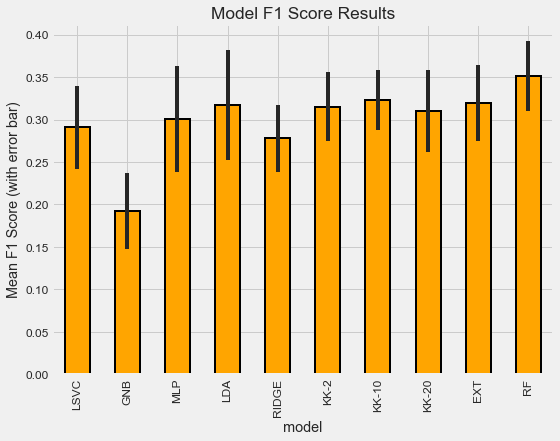

In [156]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

In [159]:
model_results.reset_index(inplace=True)

In [ ]:

for col in nums_missing.index:
    print('Column: {0}\nMedian: {1}\nMean: {2}\nMode: {3}\n--------'.format(col,
        all_data_v2[col].median(), all_data_v2[col].mean(), all_data_v2[col].mode()))
 

In [ ]:
   
# Replacing the missing values with its mean
impute_by_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0) 
all_data_v2.loc[:, nums_missing.index] = impute_by_mean.fit_transform(
    all_data_v2.loc[:, nums_missing.index])

In [7]:
# Looking at the data, one intersting observation is that any single person will
# not provide as a well picature as an entire family
# Lets create one df where we group the households

family_active = all_data['idhogar'].value_counts().reset_index()
family_active['idhogar_count'] = family_active['idhogar']
family_active.drop(['idhogar'], axis=1, inplace=True)

In [8]:
family_active.head(5)

,index,idhogar_count
0,9a906088e,13
1,fd8a6d014,13
2,830539cad,13
3,8e9159699,13
4,0c7436de6,12


In [9]:
all_data = pd.merge(all_data, family_active, left_on="idhogar", right_on="index")
all_data_grouped = all_data.set_index(['idhogar', 'Id'])
all_data_grouped.tail(5)

v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
idhogar   Id                                                              
3aa78c56b ID_a065a7cad   NaN       1      2       1     1       1     0   
d237404b6 ID_1a7c6953b   NaN       0      3       0     1       1     0   
          ID_07dbb4be2   NaN       0      3       0     1       1     0   
          ID_34d2ed046   NaN       0      3       0     1       1     0   
          ID_34754556f   NaN       0      3       0     1       1     0   

                        v18q1  r4h1  r4h2      ...        SQBhogar_total  \
idhogar   Id                                   ...                         
3aa78c56b ID_a065a7cad    NaN     0     2      ...                    36   
d237404b6 ID_1a7c6953b    NaN     0     1      ...                    16   
          ID_07dbb4be2    NaN     0     1      ...                    16   
          ID_34d2ed046    NaN     0     1      ...                    16   
          ID_34754556f    NaN     0     1      ...                    16   

                        SQBedjefe  SQBhogar_nin  SQBovercrowding  \
idhogar   Id                                                       
3aa78c56b ID_a065a7cad         25             4             36.0   
d237404b6 ID_1a7c6953b         36             4              4.0   
          ID_07dbb4be2         36             4              4.0   
          ID_34d2ed046         36             4              4.0   
          ID_34754556f         36             4              4.0   

                        SQBdependency  SQBmeaned  agesq  Target      index  \
idhogar   Id                                                                 
3aa78c56b ID_a065a7cad           0.25    33.0625    100    None  3aa78c56b   
d237404b6 ID_1a7c6953b           1.00    36.0000   2916    None  d237404b6   
          ID_07dbb4be2           1.00    36.0000    144    None  d237404b6   
          ID_34d2ed046           1.00    36.0000    144    None  d237404b6   
          ID_34754556f           1.00    36.0000   2601    None  d237404b6   

                        idhogar_count  
idhogar   Id                           
3aa78c56b ID_a065a7cad              6  
d237404b6 ID_1a7c6953b              4  
          ID_07dbb4be2              4  
          ID_34d2ed046              4  
          ID_34754556f              4  

[5 rows x 143 columns]

In [10]:
# Evaulating columns that are different btw. diff "Id" and diff "idhogar"
temp_idhogar = all_data_grouped[all_data_grouped['index'] == "d237404b6"]
temp_df = temp_idhogar.iloc[0,:] == temp_idhogar.iloc[1,:]
temp_true_cols = temp_df[temp_df == True]
temp_false_cols = temp_df[temp_df == False]

In [11]:
temp_idhogar[temp_false_cols.index]

v2a1  v18q1  escolari  rez_esc  dis  male  female  \
idhogar   Id                                                                
d237404b6 ID_1a7c6953b   NaN    NaN         6      NaN    0     1       0   
          ID_07dbb4be2   NaN    NaN         4      1.0    1     0       1   
          ID_34d2ed046   NaN    NaN         5      0.0    0     0       1   
          ID_34754556f   NaN    NaN         6      NaN    0     0       1   

                        estadocivil2  estadocivil7  parentesco1  parentesco3  \
idhogar   Id                                                                   
d237404b6 ID_1a7c6953b             1             0            1            0   
          ID_07dbb4be2             0             1            0            1   
          ID_34d2ed046             0             1            0            1   
          ID_34754556f             1             0            0            0   

                        instlevel2  instlevel3  age  SQBescolari  SQBage  \
idhogar   Id                                                               
d237404b6 ID_1a7c6953b           0           1   54           36    2916   
          ID_07dbb4be2           1           0   12           16     144   
          ID_34d2ed046           1           0   12           25     144   
          ID_34754556f           0           1   51           36    2601   

                        agesq Target  
idhogar   Id                          
d237404b6 ID_1a7c6953b   2916   None  
          ID_07dbb4be2    144   None  
          ID_34d2ed046    144   None  
          ID_34754556f   2601   None

In [12]:
# The true/false cols will give us columns names for when we group the dataset
cols_groupby_mean = temp_true_cols.index.tolist()
cols_groupby_sum = temp_false_cols.index.tolist()

# However, there are cols that could have been different but just happen to be the same
estado_cols = Preprocessing.get_similar_cols(all_data_grouped, "estado")
parente_cols = Preprocessing.get_similar_cols(all_data_grouped, "parente")
instlevel_cols = Preprocessing.get_similar_cols(all_data_grouped, "instlevel")

# Removing cols from the groupby_mean since they could have been false but coincidentally happen not to be
cols_groupby_mean = [col for col in cols_groupby_mean if col not in estado_cols]
cols_groupby_mean = [col for col in cols_groupby_mean if col not in parente_cols]
cols_groupby_mean = [col for col in cols_groupby_mean if col not in instlevel_cols]

# Adding the cols removed from the 'groupby_mean' and inserted to the 'groupby_sum'
add_to_sum = estado_cols+parente_cols+instlevel_cols
cols_groupby_sum.extend(add_to_sum)

In [13]:
all_data_grouped.head(5)

v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
idhogar   Id                                                                  
21eb7fcc1 ID_279628684  190000.0       0      3       0     1       1     0   
0e5d7a658 ID_f29eb3ddd  135000.0       0      4       0     1       1     1   
2c7317ea8 ID_68de51c94       NaN       0      8       0     1       1     0   
2b58d945f ID_d671db89c  180000.0       0      5       0     1       1     1   
          ID_d56d6f5f5  180000.0       0      5       0     1       1     1   

                        v18q1  r4h1  r4h2      ...        SQBhogar_total  \
idhogar   Id                                   ...                         
21eb7fcc1 ID_279628684    NaN     0     1      ...                     1   
0e5d7a658 ID_f29eb3ddd    1.0     0     1      ...                     1   
2c7317ea8 ID_68de51c94    NaN     0     0      ...                     1   
2b58d945f ID_d671db89c    1.0     0     2      ...                    16   
          ID_d56d6f5f5    1.0     0     2      ...                    16   

                        SQBedjefe  SQBhogar_nin  SQBovercrowding  \
idhogar   Id                                                       
21eb7fcc1 ID_279628684        100             0         1.000000   
0e5d7a658 ID_f29eb3ddd        144             0         1.000000   
2c7317ea8 ID_68de51c94          0             0         0.250000   
2b58d945f ID_d671db89c        121             4         1.777778   
          ID_d56d6f5f5        121             4         1.777778   

                        SQBdependency  SQBmeaned  agesq  Target      index  \
idhogar   Id                                                                 
21eb7fcc1 ID_279628684            0.0      100.0   1849       4  21eb7fcc1   
0e5d7a658 ID_f29eb3ddd           64.0      144.0   4489       4  0e5d7a658   
2c7317ea8 ID_68de51c94           64.0      121.0   8464       4  2c7317ea8   
2b58d945f ID_d671db89c            1.0      121.0    289       4  2b58d945f   
          ID_d56d6f5f5            1.0      121.0   1369       4  2b58d945f   

                        idhogar_count  
idhogar   Id                           
21eb7fcc1 ID_279628684              1  
0e5d7a658 ID_f29eb3ddd              1  
2c7317ea8 ID_68de51c94              1  
2b58d945f ID_d671db89c              4  
          ID_d56d6f5f5              4  

[5 rows x 143 columns]

In [14]:
# With the information above in hand, we can groupby the cols
df_groupby_mean = all_data.groupby(['idhogar'])[cols_groupby_mean].mean().reset_index()
df_groupby_sum = all_data.groupby(['idhogar'])[cols_groupby_sum].sum().reset_index()

# Must delete one of the idhogar from the dfs
df_groupby_mean.drop(['idhogar'], axis=1, inplace=True)

all_data_v2 = pd.concat([df_groupby_mean, df_groupby_sum], axis=1)
all_data_v2.head(5)

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,parentesco12,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,4,0,1,1,1,1,1,2,0,...,0,1,0,0,0,0,0,0,2,0
1,0,5,0,1,1,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,0
2,0,6,0,1,1,0,0,2,2,0,...,0,0,0,1,1,1,0,0,1,0
3,0,6,0,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,0,3,0,1,1,0,2,1,3,0,...,0,2,0,1,1,0,0,0,0,0


In [15]:
# Shape of our new dataframe (by idhogar)
all_data_v2.shape

(10340, 145)

### Data Cleaning

In [16]:
def remove_missing_columns(data, threshold=.4, verbose=False):
    total = data.apply(lambda x: sum(x.isnull()), axis=0).sort_values(ascending=False)
    percent = data.apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    to_remove = df[df['Percentage'] > threshold]
    if verbose:
        print("Columns to be removed are \n{0}".format(to_remove))
    try:
        return data.drop((to_remove).index, axis=1)  
    except:
        print("Training set did not have missing values with a treshold of {0}".format(threshold))

In [17]:
remove_missing_columns(all_data_v2, threshold=.2, verbose=True)

Columns to be removed are 
Empty DataFrame
Columns: [Total, Percentage]
Index: []
Training set did not have missing values with a treshold of 0.2


In [18]:
# Separting the numeric and object columnac
num_cols, obj_cols = Preprocessing.get_dtypes(all_data_v2, verbose=True)

There are 144 numeric cols: Index(['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'v18q', 'r4h1', 'r4h2',
       'r4h3', 'r4m1',
       ...
       'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4',
       'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9'],
      dtype='object', length=144)
There are 1 object cols: Index(['idhogar'], dtype='object')
There are total cols: 145


### Skewness

In [19]:
# Analyzing if there is any skewness in the data. Meaning, we might have ppl with very large incomes (outliers)
# We can apply the log function to normalize it 
numeric_skew_df = all_data_v2[num_cols].apply(lambda x: skew(x.dropna()))
numeric_skew_df = numeric_skew_df[numeric_skew_df > .75]

# Applying the log function to data that that is skewed more than .75
all_data_v2.loc[:, numeric_skew_df.index] = np.log1p(all_data_v2.loc[:, numeric_skew_df.index])

### Missing Values

In [20]:
# Checking for columns with the most missing values
# head=2, bc only 2 values were missing

nums_missing = all_data_v2[num_cols].apply(
    lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False).head(2)

for col in nums_missing.index:
    print('Column: {0}\nMedian: {1}\nMean: {2}\nMode: {3}\n--------'.format(col,
        all_data_v2[col].median(), all_data_v2[col].mean(), all_data_v2[col].mode()))
    
# Replacing the missing values with its mean
impute_by_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0) 
all_data_v2.loc[:, nums_missing.index] = impute_by_mean.fit_transform(
    all_data_v2.loc[:, nums_missing.index])

Column: meaneduc
Median: 8.5
Mean: 9.066094572499992
Mode: 0    6.0
dtype: float64
--------
Column: SQBmeaned
Median: 4.293878247897177
Mean: 4.162649474821759
Mode: 0    3.610918
dtype: float64
--------


In [21]:
# Lets look at the categorical dtypes for missing values
# Not categorical values are missing
objt_missing = all_data_v2[obj_cols].apply(lambda x: sum(x.isnull())/len(x), axis=0).sort_values(ascending=False)
objt_missing = objt_missing[objt_missing>0]
objt_missing

Series([], dtype: float64)

In [22]:
# No need to create dummy variable 
# Discrete variables that are supposed in dummy var format are already

In [23]:
# Saving a copy of the cleaned df
all_data_v2_clean = all_data_v2.copy()

### Feature Scaling

In [24]:
# We will create a new separate df that standarizes the data
def get_standarized_data(data, x_labels):
    features = data[x_labels]
    features = preprocessing.StandardScaler().fit_transform(features.values)
    data[x_labels] = features
    return data

all_data_v2_std = get_standarized_data(all_data_v2, num_cols)

In [25]:
# Deleting squared columns for std and normal data
squared_columns = Preprocessing.get_similar_cols(all_data_v2_clean, "SQ")
all_data_v2_clean = all_data_v2_clean.drop(squared_columns, axis=1)

squared_columns = Preprocessing.get_similar_cols(all_data_v2_std, "SQ")
all_data_v2_std = all_data_v2_std.drop(squared_columns, axis=1)

### Saving Cleaned Data

In [26]:
# Saving all_data_v2
# Through the process, target var was removed (must insert back)
target_df = all_data[['idhogar', 'Target']]
all_data_v2_clean = pd.merge(all_data_v2_clean, target_df, left_on="idhogar", right_on="idhogar")
all_data_v2_std = pd.merge(all_data_v2_std, target_df, left_on="idhogar", right_on="idhogar")

In [27]:
# Setting up the train_set/test_set for feature engineering and machine learning
train_set = all_data_v2_clean[~all_data_v2_clean['Target'].isna()]
test_set = all_data_v2_clean[all_data_v2_clean['Target'].isna()]

# Saving the sets for future use
train_set.to_pickle("./pickles/train.pkl")
test_set.to_pickle("./pickles/test.pkl")

# Performing the same steps for the std set
# Setting up the train_set/test_set for feature engineering and machine learning
train_set_std = all_data_v2_std[~all_data_v2_std['Target'].isna()]
test_set_std = all_data_v2_std[all_data_v2_std['Target'].isna()]

# Saving the sets for future use
train_set_std.to_pickle("./pickles/train_v2.pkl")
test_set_std.to_pickle("./pickles/test_v2.pkl")

In [28]:
all_data_v2_clean.shape, all_data_v2_std.shape

((33413, 138), (33413, 138))

In [29]:
all_data_v2_clean.head()

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,Target
0,0.0,4,0.0,1,1,0.693147,0.693147,0.693147,1.098612,0.0,...,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,None
1,0.0,4,0.0,1,1,0.693147,0.693147,0.693147,1.098612,0.0,...,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,None
2,0.0,4,0.0,1,1,0.693147,0.693147,0.693147,1.098612,0.0,...,0.693147,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,None
3,0.0,5,0.0,1,1,0.000000,0.000000,0.693147,0.693147,0.0,...,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,None
4,0.0,5,0.0,1,1,0.000000,0.000000,0.693147,0.693147,0.0,...,0.693147,0.693147,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,None


In [30]:
all_data_v2_std.head(5)

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,Target
0,-0.167749,-0.536571,-0.12457,0.083738,0.217731,1.889221,1.525304,-0.167557,0.550800,-0.500961,...,1.073201,-0.770802,-0.889562,-0.811347,-0.612851,-0.22809,-0.206019,1.938357,-0.204149,None
1,-0.167749,-0.536571,-0.12457,0.083738,0.217731,1.889221,1.525304,-0.167557,0.550800,-0.500961,...,1.073201,-0.770802,-0.889562,-0.811347,-0.612851,-0.22809,-0.206019,1.938357,-0.204149,None
2,-0.167749,-0.536571,-0.12457,0.083738,0.217731,1.889221,1.525304,-0.167557,0.550800,-0.500961,...,1.073201,-0.770802,-0.889562,-0.811347,-0.612851,-0.22809,-0.206019,1.938357,-0.204149,None
3,-0.167749,0.129953,-0.12457,0.083738,0.217731,-0.529319,-0.513819,-0.167557,-0.401382,-0.500961,...,1.073201,0.810138,-0.889562,-0.811347,-0.612851,-0.22809,-0.206019,-0.645376,-0.204149,None
4,-0.167749,0.129953,-0.12457,0.083738,0.217731,-0.529319,-0.513819,-0.167557,-0.401382,-0.500961,...,1.073201,0.810138,-0.889562,-0.811347,-0.612851,-0.22809,-0.206019,-0.645376,-0.204149,None
